In [4]:
from __future__ import division
import numpy as np
import os
import sys
import time
import functools
import pickle
import multiprocess
from sklearn.utils import shuffle
from algorithms import Problem
import utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
fig_path = os.getcwd()
show_fig = True
save_fig = False

## Parallel Sweep of Paper Count

In [6]:
def sweep_papers(s_funcs, params, name):
    
    for axis, pairs in zip([paper_axis], [paper_pairs]):
        for param in params:
            for func_index, s_func in enumerate(s_funcs):
                data = parallel_sweep(s_func, g_p, g_r, f, f_tilde, noise, 
                                      special, stop, poisson, subset, seed, count, param, hyper, pairs)

                xlabel = 'Number of papers'
                param_fi = str(param[0]).replace('.', '') + '_' + str(param[1]).replace('.', '')
                
                fi_fig = os.path.join(fig_path, name + 'papers_func' + str(func_index) + 'params_' + param_fi +  '.pdf')
                utils.sweep_comparison_plot(data, axis, xlabel, fi_fig, show_fig, save_fig)

def parallel_sweep(s_func, g_p, g_r, f, f_tilde, noise, special, stop, poisson, 
                   subset, seed, count, param, hyper, pairs): 
             
    parallel_sim = functools.partial(sweep_simulation, s_func, g_p, g_r, f, 
                                     f_tilde, noise, special, stop, poisson, subset, seed, count, param, hyper)
    pool = multiprocess.Pool()
    
    data = pool.map(parallel_sim, pairs)
    pool.close()
    pool.join()
    
    return data


def sweep_simulation(s_func, g_p, g_r, f, f_tilde, noise, special, stop, poisson, 
                     subset, seed, count, param, hyper, pair):  
    
    np.random.seed(seed)
    
    # Finding parameter to balance paper side and reviewer side gain.
    hyper = 1
    while True:
        s_list = [shuffle(s_func(pair, param)) for _ in xrange(10)]
        random = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                         special=special, stop=stop, poisson=poisson, subset=subset)
        random.simulate(random.random_policy, seed)
        if abs(1 - random.p_gain_mean/random.r_gain_mean) < .02:
            break
        hyper *= (random.p_gain_mean/random.r_gain_mean)
    
    algs = []
    
    np.random.seed(seed)
    
    T, d = pair[0], pair[1]
            
    s_list = [shuffle(s_func(pair, param)) for _ in xrange(count)]

    super_random_heuristic = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, 
                                     hyper=hyper, special=special, stop=stop, poisson=poisson, subset=subset)
    super_random_heuristic.simulate(super_random_heuristic.super_random_heuristic_policy, seed)

    super_zero_heuristic = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                                   special=special, stop=stop, poisson=poisson, subset=subset)
    super_zero_heuristic.simulate(super_zero_heuristic.super_zero_heuristic_policy, seed)

    sim = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                  special=special, stop=stop, poisson=poisson, subset=subset)
    sim.simulate(sim.sim_policy, seed)

    bid = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                  special=special, stop=stop, poisson=poisson, subset=subset)
    bid.simulate(bid.bid_policy, seed)

    random = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                     special=special, stop=stop, poisson=poisson, subset=subset)
    random.simulate(random.random_policy, seed)

    algs = [super_random_heuristic, super_zero_heuristic, sim, bid, random]

    data = [(algs[i].gain_mean, algs[i].gain_se) for i in xrange(len(algs))]
    
    return data

## Similarity Matrix Creation

In [7]:
low_rank_beta_10 = lambda pair, param: sum(np.dot(np.random.beta(param[0], param[1], pair[0]).reshape(-1, 1), 
                      np.random.beta(param[0], param[1], pair[1]).reshape(1, -1)) for _ in xrange(10))/10.

## Gain and Bidding Functions

In [11]:
# Gain functions for paper-side gain.                     
sqrt = lambda d: np.sqrt(d)
minimum_3 = lambda d: np.minimum(d, 3)

# Gain functions for reviewer-side gain.
DCG = lambda s, pi: (2**(s)-1)/np.log2(pi + 1)

# Bidding functions.
bid_log = lambda pi: 1./np.log2(pi + 1)
bid_sqrt = lambda pi: 1./np.sqrt(pi)

## Paper and Reviewer Sweep Simulations Gain Functions

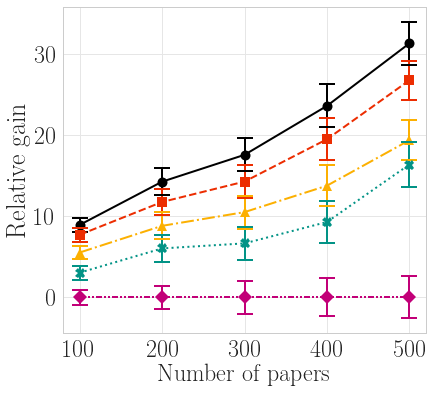

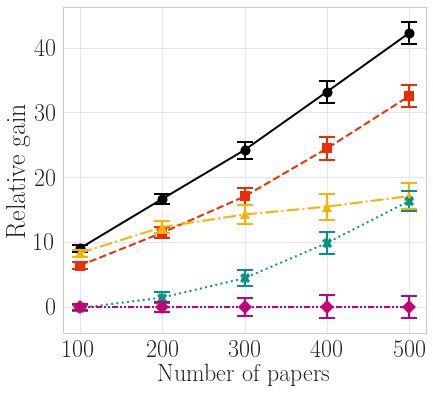

In [13]:
g_p_list = [sqrt, minimum_3]
name_list = ['sqrt_', 'minimum3_']

for g_p, name_begin in zip(g_p_list, name_list):
    g_r = DCG
    f = bid_log
    f_tilde = bid_log
    noise = 0
    hyper = 0.
    special = True
    stop = lambda x: x
    poisson = False
    subset = False
    seed = 0
    count = 50

    low_rank_beta_s_funcs = [low_rank_beta_10]
    beta_params = [(5, 2)]
    low_rank_beta_name = name_begin + 'low_rank_beta_'

    paper_pairs = [(100, 100), (100, 200), (100, 300), (100, 400), (100, 500)]
    paper_axis = [x[1] for x in paper_pairs]

    sweep_papers(low_rank_beta_s_funcs, beta_params, low_rank_beta_name)

## Mismatch Paper and Reviewer Sweep Simulations Gain Functions

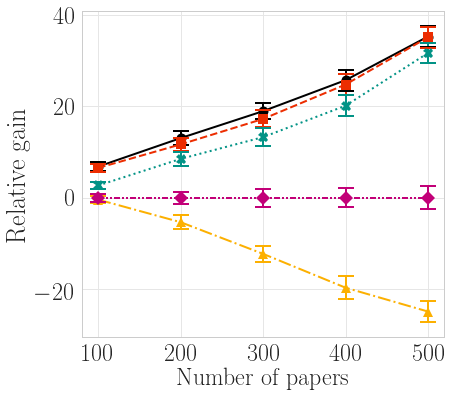

In [15]:
g_p_list = [sqrt]
name_list = ['sqrt_']

for g_p, name_begin in zip(g_p_list, name_list):
    g_r = DCG
    f = bid_log
    f_tilde = bid_sqrt
    noise = 0
    hyper = 0.
    special = True
    stop = lambda x: x
    poisson = False
    subset = False
    seed = 0
    count = 50

    low_rank_beta_s_funcs = [low_rank_beta_10]
    beta_params = [(5, 2)]
    low_rank_beta_name = name_begin + 'low_rank_beta_'

    paper_pairs = [(100, 100), (100, 200), (100, 300), (100, 400), (100, 500)]
    paper_axis = [x[1] for x in paper_pairs]

    sweep_papers(low_rank_beta_s_funcs, beta_params, low_rank_beta_name)

## Stop Early Paper and Reviewer Sweep Simulations

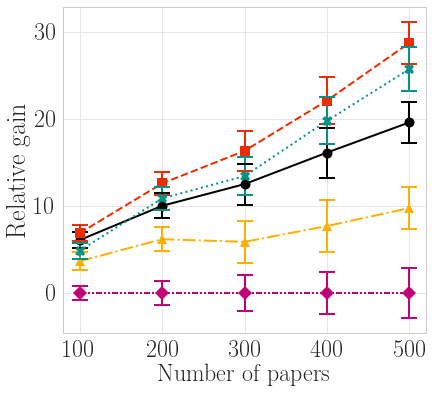

In [16]:
g_p_list = [sqrt]
name_list = ['sqrt_']

for g_p, name_begin in zip(g_p_list, name_list):
    g_r = DCG
    f = bid_log
    f_tilde = bid_log
    noise = 0
    hyper = 0.
    special = True
    stop = lambda x: int(x/2)
    poisson = False
    subset = False
    seed = 0
    count = 50

    low_rank_beta_s_funcs = [low_rank_beta_10]
    beta_params = [(5, 2)]
    low_rank_beta_name = name_begin + 'low_rank_beta_'

    paper_pairs = [(100, 100), (100, 200), (100, 300), (100, 400), (100, 500)]
    paper_axis = [x[1] for x in paper_pairs]

    sweep_papers(low_rank_beta_s_funcs, beta_params, low_rank_beta_name)

## Poisson Paper and Reviewer Sweep Simulations

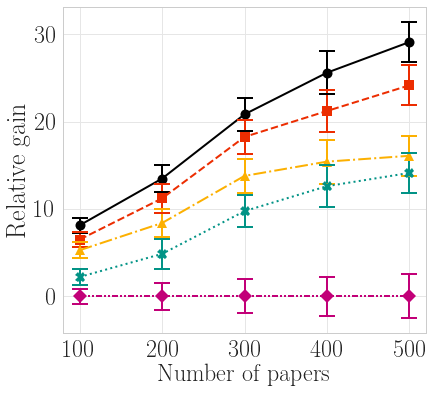

In [17]:
g_p_list = [sqrt]
name_list = ['sqrt_']

for g_p, name_begin in zip(g_p_list, name_list):
    g_r = DCG
    f = bid_log
    f_tilde = bid_log
    noise = 0
    hyper = 0.
    special = True
    stop = lambda x: x
    poisson = True
    subset = False
    seed = 0
    count = 50

    low_rank_beta_s_funcs = [low_rank_beta_10]
    beta_params = [(5, 2)]
    low_rank_beta_name = name_begin + 'low_rank_beta_'

    paper_pairs = [(100, 100), (100, 200), (100, 300), (100, 400), (100, 500)]
    paper_axis = [x[1] for x in paper_pairs]

    sweep_papers(low_rank_beta_s_funcs, beta_params, low_rank_beta_name)